# **Fake News Analysis and Detection with Naive Bayes**

## **Requirements**

In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from wordcloud import WordCloud
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline

In [4]:
sys.path.insert(0, r"C:\Users\fscielzo\Documents\Packages\BigEDA_Package_Private")
from BigEDA.plots import barplot

sys.path.insert(0, r"C:\Users\fscielzo\Documents\Packages\PyML_Package_Private")
from PyML.evaluation import SimpleEvaluation

In [5]:
class Naive_TFIDF_Classifier(BaseEstimator, ClassifierMixin):

    def __init__(self, n_top_train=10, n_top_new=10):
        self.n_top_train = n_top_train
        self.n_top_new = n_top_new

    def fit(self, X, y):

        self.classes_ = np.unique(y)
        self.top_tokens_train_class_ = {}
        for c in self.classes_:
            tfidf_mean_class = np.array(np.mean(X[y == c, :], axis=0))[0] 
            self.top_tokens_train_class_[c] = np.argsort(-tfidf_mean_class)[:self.n_top_train]        
        return self

    def predict(self, X):
        
        Y_hat = []
        for i in range(X.shape[0]):  
            top_tokens_new = np.argsort(-X[i].toarray())[0][:self.n_top_new]
            prop_matches = {}
            for c in self.classes_:
                prop_matches[c] = np.mean([x in self.top_tokens_train_class_[c] for x in top_tokens_new]) 

            prop_matches_values = list(prop_matches.values())
            Y_hat.append(self.classes_[np.argmax(prop_matches_values)])
        return np.array(Y_hat)

In [6]:
class SparseToDense(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.toarray()
        return X        

## **Introduction**


In this work we will analyze and classify News as Fake or Not Fake, by applying  supervised classification algorithms, such as the naive Bayes classifier.


## **Data**

The data-set that we are going to use contains 44898 News about American politics issues between 31 March 2015 and 18 february 2018. Some of them are Fake News, others not, and we have this information in a variable, which will be the response variable.

This data-set was download from `Kaggle`, but the its link is not available anymore.

We load the data an create the response variable, which indicates if the news is Fake (1) or not (0).

In [7]:
fake_df = pl.read_csv('Fake.csv')
true_df = pl.read_csv('True.csv')
df_True = true_df.with_columns(pl.Series(np.repeat(0, len(true_df))).alias('Fake'))
df_Fake = fake_df.with_columns(pl.Series(np.repeat(1, len(fake_df))).alias('Fake'))
news_df = pl.concat([df_Fake, df_True], how='vertical')

# Fake = 0 = False --> True News
# Fake = 1 = Yes --> Fake News

In [8]:
news_df.head(7)

title,text,subject,date,Fake
str,str,str,str,i32
"""Donald Trump S…","""Donald Trump j…","""News""","""December 31, 2…",1
"""Drunk Bragging…","""House Intellig…","""News""","""December 31, 2…",1
"""Sheriff David …","""On Friday, it …","""News""","""December 30, 2…",1
"""Trump Is So Ob…","""On Christmas d…","""News""","""December 29, 2…",1
"""Pope Francis J…","""Pope Francis u…","""News""","""December 25, 2…",1
"""Racist Alabama…","""The number of …","""News""","""December 25, 2…",1
""" Fresh Off The…","""Donald Trump s…","""News""","""December 23, 2…",1


In [9]:
news_df.shape

(44898, 5)

## **News topics**

We can compute the weight (relative frequency) of the different topics covered in the news.

In [10]:
unique_subjects, count_subjects = np.unique(news_df['subject'], return_counts=True)
unique_subjects_sorted = unique_subjects[np.argsort(-count_subjects)]
freq_subjects_sorted = count_subjects[np.argsort(-count_subjects)]
rel_freq_subjects_sorted = np.round(freq_subjects_sorted / np.sum(freq_subjects_sorted), 3) * 100
news_subjects_rel_freq = pl.DataFrame({'subjects':unique_subjects_sorted, 'rel_freq_%':rel_freq_subjects_sorted})
news_subjects_rel_freq

subjects,rel_freq_%
str,f64
"""politicsNews""",25.1
"""worldnews""",22.6
"""News""",20.2
"""politics""",15.2
"""left-news""",9.9
"""Government New…",3.5
"""US_News""",1.7
"""Middle-east""",1.7


As you we can see, the most part of the news are about politics, focus on the USA scenario, but there are also a significance amount of world news.

## **News types**

We visualize the weight (relative frequencies) of both news types (fake and not fake).

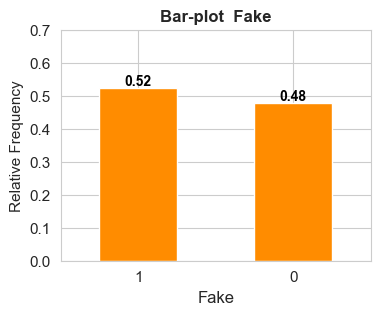

Fake = 1 = Yes --> Fake News 
Fake = 0 = False --> Not Fake News


In [11]:
barplot(X=news_df['Fake'], color='darkorange', figsize=(4,3), fontsize=10,  
        y_up_limit=0.7, xlabel='Fake', xlabel_size=12, title_size=12) 
print('Fake = 1 = Yes --> Fake News \nFake = 0 = False --> Not Fake News')

We can see that both classes are well balance, since we have 52% of fake news and 48% of not fake.

## **Number of words per news type**

Computing the number of words of each document and grouping by `Fake`.

In [12]:
corpus = news_df['text'].to_numpy()
n_news = len(corpus)
words_count = [len(corpus[i].split()) for i in range(0,n_news)]
news_df = news_df.with_columns(pl.Series(words_count).alias('words_count'))
news_df.group_by('Fake').agg(pl.col('words_count').mean())

Fake,words_count
i32,f64
0,385.640099
1,423.197905


We can see that hte fake news has, on average, 423 words, and the not fake 385.

## **Tokenizer**

Defining a tokenizer, that is, a function that takes text as input and return the tokens of that text as output.

This tokenizer is going to define what is a token a what is not. In general terms a token will be a word that fulfill certain conditions, in this case the ones that define our `tokenizer` function.

In [13]:
def tokenizer(text) :
    
    # Text is converted to lowercase.
    new_text = text.lower()
    # Removing web pages links.
    new_text = re.sub('http\S+', ' ', new_text)
    # Removing  punctuation marks.
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'    
    new_text = re.sub(regex , ' ', new_text)
    # Removing numbers.
    new_text = re.sub("\d+", ' ', new_text)
    # Removing multiple white spaces.
    new_text = re.sub("\\s+", ' ', new_text)
    # Tokenization based on individual words.
    new_text = new_text.split(sep = ' ')
    # Removing tokens with length <= 1
    new_text = [token for token in new_text if len(token) >=  2]
    
    return new_text

<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\fscielzo\AppData\Local\Temp\ipykernel_20212\2381969994.py:6: SyntaxWarning: invalid escape sequence '\S'
  new_text = re.sub('http\S+', ' ', new_text)
C:\Users\fscielzo\AppData\Local\Temp\ipykernel_20212\2381969994.py:11: SyntaxWarning: invalid escape sequence '\d'
  new_text = re.sub("\d+", ' ', new_text)


Example to show how this function works:

In [14]:
text = 'My email is fabio@gmail.com. This project was carried out in 2024. The web page of this university is: https://www.uc3m.es/Home'

In [15]:
np.array(tokenizer(text))

array(['my', 'email', 'is', 'fabio', 'gmail', 'com', 'this', 'project',
       'was', 'carried', 'out', 'in', 'the', 'web', 'page', 'of', 'this',
       'university', 'is'], dtype='<U10')

## **Stopwords**

Defining the stop words, that is, words that we will consider as not significative, so that, we will not be consider as tokens.

In [16]:
stop_words = stopwords.words('english') + ["pic" , "getty", "quot", "acr", "filessupport", "flickr", "fjs", "js", 
                                           "somodevilla", "var", "henningsen","ck", "cdata", "subscribing", "mcnamee", 
                                           "amp", "wfb", "screenshot", "hesher","nyp", "cking", "helton", "raedle", 
                                           "donnell", "getelementbyid", "src", "behar", "createelement", "getelementsbytagname", 
                                           "parentnode", "wnd","insertbefore", "jssdk", "nowicki", "xfbml", "camerota", 
                                           "sdk",  "“i" , "“the", "“we", "it’s", "don’t", "“this", "“it", "“a",
                                           "“if",  "“it’s", "we’re", "that’s",  "“he", "“there", "i’m",  "he’s",  "“we’re", 
                                           "doesn’t", "can’t", "“i’m", "“in", "suu", "“they", "you’re", "“but", "didn’t", 
                                           "“you", "they’re", "“no", "“as", "“very" , "there’s", "“what",  "“and", "won’t",
                                           "“to", "“that", "“one", "we’ve", "“when" , "“our", "“not", "’”" ,"“that’s", 
                                           "“these", "“there’s", "“he’s", "we’ll", 'one', 'would', 'like', 'us', 'even', 
                                           'could', 'two', 'many', 'angerer', 'reilly', 'said', 'told', 'also', 'via']

## **Computing Tokens**

In [17]:
# Computing the tokens for each document (news)
tokens = news_df['text'].map_elements(tokenizer)
# Adding the tokens and and ID for the documents (news) as variables
news_df = news_df.with_columns(tokens.alias('tokens'), pl.Series(np.arange(0,len(news_df))).alias('text_id'))
# Explode the data-frame by `tokens` column
tokens_explode_df = news_df[['text_id','tokens', 'Fake']].explode(columns=['tokens'])
# Removing stopwords form the tokens
tokens_explode_df = tokens_explode_df.filter(~ pl.col('tokens').is_in(stop_words))
# Computing the frequency (count) of each token grouped by `Fake` colum.
tokens_df = pl.from_pandas(tokens_explode_df.to_pandas().groupby(by=['tokens', 'Fake'] )['tokens'].count().unstack(fill_value=0).stack().reset_index(name='count'))
# Computing the frequency (count) of tokens per document (News)
tokens_count = [len(tokens[i]) for i in range(0, n_news)]
# Adding the las array as column of `news_df`
news_df = news_df.with_columns(pl.Series(tokens_count).alias('tokens_count')) 
# Computing unique tokens and counting their frequency.
unique_tokens, count_tokens = np.unique(tokens_explode_df['tokens'], return_counts=True)

- Data-frame with the tokens, and their counts depending on the news type.

In [18]:
tokens_df.head()

tokens,Fake,count
str,i32,i64
"""aa""",0,22
"""aa""",1,24
"""aaa""",0,7
"""aaa""",1,9
"""aaaaaaaand""",0,0


- Data-frame with all the tokens for each news. `text_id` is a variable for indexing the news.

In [19]:
tokens_explode_df.head()

text_id,tokens,Fake
i32,str,i32
0,"""donald""",1
0,"""trump""",1
0,"""wish""",1
0,"""americans""",1
0,"""happy""",1


In [20]:
tokens_explode_df.tail()

text_id,tokens,Fake
i32,str,i32
44897,"""energy""",0
44897,"""technology""",0
44897,"""aviation""",0
44897,"""among""",0
44897,"""others""",0


The number of tokens (counting repetitions) is:

In [21]:
len(tokens_explode_df)

9977651

That is the same as the sum of the counts of all the tokens:

In [22]:
tokens_df['count'].sum() 

9977651

But the number of unique tokens is: 

In [23]:
n_classes = 2
int(len(tokens_df) / n_classes)

125562

## **Average number of tokens per news type**

We can compute the average number of tokens depending of the news type.

In [24]:
# Number of tokens grouped by `Fake` 
news_df.group_by('Fake').agg(pl.col('tokens_count').mean().round())

Fake,tokens_count
i32,f64
0,368.0
1,409.0


Fake news has 409 tokens on average, and not fake 368.

## **Top tokens per news type based on frequency**

We compute the most frequent tokens depending on the news type, then we plot the top tokens in both groups.

In [25]:
# Computing the most frequent tokens in Fake and not Fake news.
top_fake_tokens_count = tokens_df.filter(pl.col('Fake') == 1).sort(by='count', descending=True)['tokens'].to_numpy()
freq_top_fake_tokens_count = tokens_df.filter(pl.col('Fake') == 1).sort(by='count', descending=True)['count'].to_numpy()

top_not_fake_tokens_count = tokens_df.filter(pl.col('Fake') == 0).sort(by='count', descending=True)['tokens'].to_numpy()
freq_top_not_fake_tokens_count = tokens_df.filter(pl.col('Fake') == 0).sort(by='count', descending=True)['count'].to_numpy()

- **Barplots for top tokens**

  Plotting the top 15 tokens in the fake and not fake news, based on frequencies, as a barplot.

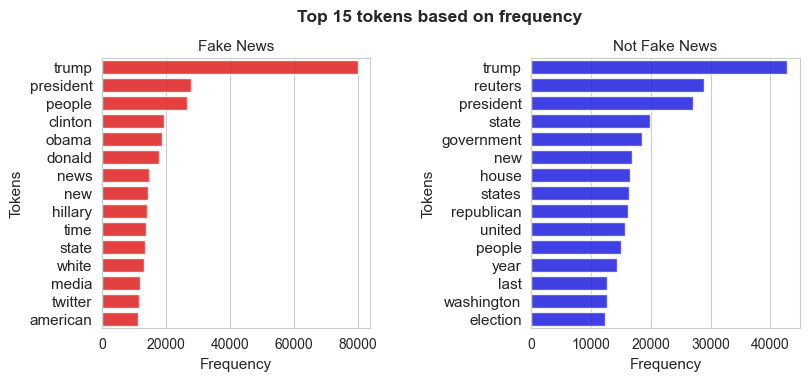

In [26]:
n_top = 15
fig, axs = plt.subplots(1,2, figsize=(9,3.5))
axes = axs.flatten()

ax = sns.barplot(x=freq_top_fake_tokens_count[:n_top], y=top_fake_tokens_count[:n_top], 
                 color='red', alpha=0.85, ax=axes[0])
ax = sns.barplot(x=freq_top_not_fake_tokens_count[:n_top], y=top_not_fake_tokens_count[:n_top], 
                 color='blue', alpha=0.85, ax=axes[1])

axes[0].set_title('Fake News', fontsize=11)
axes[1].set_title('Not Fake News', fontsize=11)

for i in range(0, len(axes)):
    axes[i].set_ylabel('Tokens', size=11)
    axes[i].set_xlabel('Frequency', size=11)
    axes[i].tick_params(axis='y', rotation=0, labelsize=11)

plt.suptitle(f'Top {n_top} tokens based on frequency', size=12.5, weight='bold', y=1.02)
plt.subplots_adjust(hspace=0.25, wspace=0.6) 
plt.show()

- Computing the **genuine** fake and not fake tokens, namely, tokens that are in the top-15 fake tokens but not in the top-15 not fake tokens, and vice versa.

In [27]:
genuine_top_fake_tokens_count_idx = np.array([x not in top_not_fake_tokens_count[:n_top] for x in top_fake_tokens_count[:n_top]])
genuine_top_not_fake_tokens_count_idx = np.array([x not in top_fake_tokens_count[:n_top] for x in top_not_fake_tokens_count[:n_top]])

genuine_top_fake_tokens_count = top_fake_tokens_count[:n_top][genuine_top_fake_tokens_count_idx]
freq_genuine_top_fake_tokens_count = freq_top_fake_tokens_count[:n_top][genuine_top_fake_tokens_count_idx]

genuine_top_not_fake_tokens_count = top_not_fake_tokens_count[:n_top][genuine_top_not_fake_tokens_count_idx]
freq_genuine_top_not_fake_tokens_count = freq_top_not_fake_tokens_count[:n_top][genuine_top_not_fake_tokens_count_idx]

- **Word clouds for genuine top tokens**

   Plotting the top genuine tokens in the fake and not fake news as a word cloud.

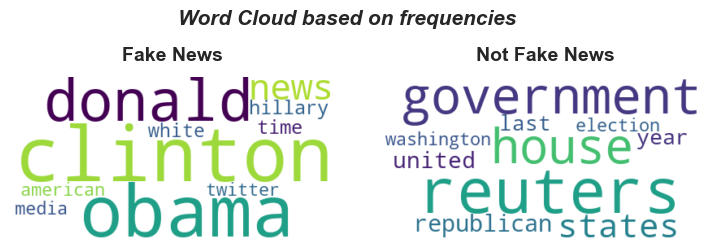

In [28]:
word_cloud_fake_data = {token: count for token, count in zip(genuine_top_fake_tokens_count, freq_genuine_top_fake_tokens_count)}
word_cloud_not_fake_data = {token: count for token, count in zip(genuine_top_not_fake_tokens_count, freq_genuine_top_not_fake_tokens_count)}
wordcloud_fake = WordCloud(width=400, height=200, background_color='white', random_state=123).generate_from_frequencies(word_cloud_fake_data)
wordcloud_not_fake = WordCloud(width=400, height=200, background_color='white', random_state=123).generate_from_frequencies(word_cloud_not_fake_data)

fig, axs = plt.subplots(1,2, figsize=(9,9))
axes = axs.flatten()

axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].imshow(wordcloud_not_fake, interpolation='bilinear')

axes[0].set_title('Fake News', fontsize=14, weight='bold', y=1.05)
axes[1].set_title('Not Fake News', fontsize=14, weight='bold', y=1.05)

for i in range(0, len(axes)):
    axes[i].axis('off') # Hide axis

plt.suptitle('Word Cloud based on frequencies', weight='bold', style='italic', fontsize=15, y=0.66)
plt.subplots_adjust(hspace=0.25, wspace=0.15) 
plt.show()

- **Interpretation**

   - The left plot shows that the most prominent words are "Obama," "Clinton," "Donald," "media," "twitter," and "news." This suggests that these terms are most frequently used in fake news. The names suggest a focus on political figures during the period, which aligns with the 2016 US presidential election. The presence of "media" and "twitter" implies these platforms might be significant in the spread or discussion of fake news.

  - The right plot displays words like "government," "Reuters," "election," "house," and "Washington." These terms are generally more formal and institutional than those in the fake news cloud. The prominence of "Reuters," a well-known international news organization, suggests a source for genuine news. The words here are more associated with official government entities and political processes.

From these word clouds, we can infer that fake news articles might be more likely to mention high-profile personalities and social media, while genuine news articles are more likely to mention institutional and government-related terms

## **Odds Ratio**

We are interested in studying which words are used in a more differentiated way in each type of news (fake / not fake), that is, words that are used a lot in fake news and little in not Fake news, and vice versa.

One way to do this analysis is through the odds ratio of the frequencies.

$$OR_{(1,0)}(t) \hspace{0.05cm}=\hspace{0.05cm}  \dfrac{P_1(t)}{P_0(t)} \hspace{0.05cm}=\hspace{0.05cm} \dfrac{\hspace{0.35cm} \dfrac{\hspace{0.15cm}n_1(t) + 1\hspace{0.15cm}}{N_1 + 1} \hspace{0.35cm}}{ \dfrac{\hspace{0.15cm} n_0(t) + 1 \hspace{0.15cm}}{N_0 +1}}$$
 
Where:

- $P_1(t)$ is the proportion of times that the token $t$ appear in the Fake news (1).

- $P_0(t)$ is the proportion of times that the token $t$ appear in the not Fake news (0).

- $n_1(t)$ the number of times the token $t$ appears in the fake news.

- $n_0(t)$ the number of times the token $t$ appears in the not fake news

- $N_1$ is the number of terms (tokens, counting repetitions) that appear in the fake news

- $N_0$ is the number of terms (tokens, counting repetitions) that appear in the not fake news

**Observation:**

$$OR_{(0,1)}(t) \hspace{0.05cm}=\hspace{0.05cm} \dfrac{1}{\hspace{0.12cm} OR_{(1,0)}(t) \hspace{0.12cm}}$$

### **Top tokens per news type based on Odds Ratio**

We compute the odds ratio of fake against not fake and vice versa, then, we plot the top 15 tokens according to the odds ratio.

In [29]:
# vectorized n parameter
def n(fake):
    return tokens_df.filter(pl.col('Fake') == fake)['count'].to_numpy()

def N(fake):
    return tokens_explode_df.group_by(by='Fake').agg(pl.col('tokens').count()).filter(pl.col('Fake') == fake)['tokens'][0]

odds_fake_notfake = ((n(1) + 1) / (N(1) + 1)) / ((n(0) + 1) / (N(0) + 1))
odds_notfake_fake = (1 / odds_fake_notfake)

top_fake_tokens_odds = unique_tokens[np.argsort(-odds_fake_notfake)]
top_not_fake_tokens_odds = unique_tokens[np.argsort(-odds_notfake_fake)]

odds_fake_notfake_sorted = odds_fake_notfake[np.argsort(-odds_fake_notfake)]
odds_notfake_fake_sorted = odds_notfake_fake[np.argsort(-odds_notfake_fake)]

- **Barplots for top tokens**

  Plotting the top 15 tokens in the fake and not fake news, based on odds ratio, as a barplot.

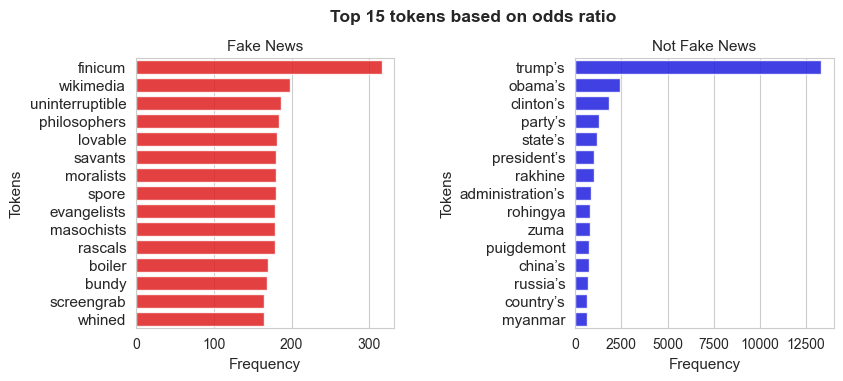

In [30]:
n_top = 15
fig, axs = plt.subplots(1,2, figsize=(9,3.5))
axes = axs.flatten()

ax = sns.barplot(y=top_fake_tokens_odds[:n_top], x=odds_fake_notfake_sorted[:n_top], 
                 color='red', alpha=0.85, ax=axes[0])
ax = sns.barplot(y=top_not_fake_tokens_odds[:n_top], x=odds_notfake_fake_sorted[:n_top], 
                 color='blue', alpha=0.85, ax=axes[1])

axes[0].set_title('Fake News', fontsize=11)
axes[1].set_title('Not Fake News', fontsize=11)

for i in range(0, len(axes)):
    axes[i].set_ylabel('Tokens', size=11)
    axes[i].set_xlabel('Frequency', size=11)
    axes[i].tick_params(axis='y', rotation=0, labelsize=11)

plt.suptitle(f'Top {n_top} tokens based on odds ratio', size=12.5, weight='bold', y=1.02)
plt.subplots_adjust(hspace=0.25, wspace=0.7) 
plt.show()

- Computing the **genuine** fake and not fake tokens, namely, tokens that are in the top-15 fake tokens but not in the top-15 not fake tokens, and vice versa.

In [31]:
genuine_top_fake_tokens_odds_idx = np.array([x not in top_not_fake_tokens_odds[:n_top] for x in top_fake_tokens_odds[:n_top]])
genuine_top_not_fake_tokens_odds_idx = np.array([x not in top_fake_tokens_odds[:n_top] for x in top_not_fake_tokens_odds[:n_top]])

genuine_top_fake_tokens_odds = top_fake_tokens_odds[:n_top][genuine_top_fake_tokens_odds_idx]
odds_genuine_top_fake_tokens = odds_fake_notfake_sorted[:n_top][genuine_top_fake_tokens_odds_idx]

genuine_top_not_fake_tokens_odds = top_not_fake_tokens_odds[:n_top][genuine_top_not_fake_tokens_odds_idx]
freq_genuine_top_not_fake_tokens_odds = odds_notfake_fake_sorted[:n_top][genuine_top_not_fake_tokens_odds_idx]

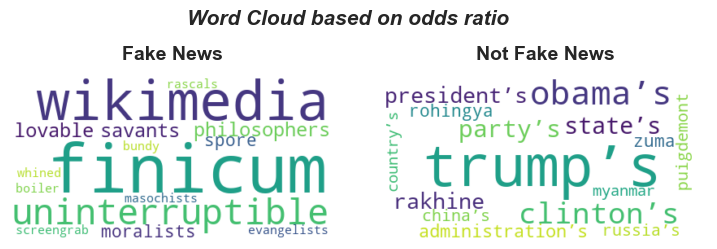

In [32]:
word_cloud_fake_data = {token: odds for token, odds in zip(genuine_top_fake_tokens_odds, odds_genuine_top_fake_tokens)}
word_cloud_not_fake_data = {token: odds for token, odds in zip(genuine_top_not_fake_tokens_odds, freq_genuine_top_not_fake_tokens_odds)}
wordcloud_fake = WordCloud(width=400, height=200, background_color='white', random_state=123).generate_from_frequencies(word_cloud_fake_data)
wordcloud_not_fake = WordCloud(width=400, height=200, background_color='white', random_state=123).generate_from_frequencies(word_cloud_not_fake_data)

fig, axs = plt.subplots(1,2, figsize=(9,8))
axes = axs.flatten()

axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].imshow(wordcloud_not_fake, interpolation='bilinear')

axes[0].set_title('Fake News', fontsize=14, weight='bold', y=1.05)
axes[1].set_title('Not Fake News', fontsize=14, weight='bold', y=1.05)

for i in range(0, len(axes)):
    axes[i].axis('off') # Hide axis

plt.suptitle('Word Cloud based on odds ratio', weight='bold', style='italic', fontsize=15, y=0.68)
plt.subplots_adjust(hspace=0.25, wspace=0.15) 
plt.show()

- **Interpretation**

  - The most important words in fake news according with the odds ratio are "finicum," "cum," "philosophers," "boiler," "uninterruptible," and "wikimedia." The presence of such terms could indicate specific topics, narratives, or sources that are more commonly found in fake news. It's worth noting that some of these words seem unusual or out of context in political news, which might suggest that fake news includes unexpected or less relevant content.

  - The left word cloud includes words like "Obama's," "Trump's," "party," "Russia's," "China's," "president's," and "state's." These terms are more clearly associated with official political discourse and international relations. The presence of possessive forms of country names and leader's names indicates that genuine news may focus more on specific actions or policies attributed to these entities or individuals.

The analysis suggests that fake news may focus on sensational or less authoritative topics, while genuine news is more likely to cover official and international matters, with a focus on specific figures and state actions.

## **Term Frequecy - Inverse Document Frequency**

One of the main interests in text mining, natural language processing and information retrieval is to quantify the subject matter of a text, as well as the importance of each term in it. A simple way to measure the importance of a term within a document is to use the frequency with which it appears (tf, term-frequency). This approach, although simple, has the limitation of attributing a lot of importance to those words that appear many times even though they do not provide selective information.

For example, if the word 'mathematics' appears 5 times in a document and the word 'page' appears 50 times, the second word will have 10 times more weight even though it does not provide as much information on the subject of the document. 

To solve this problem, the tf values can be weighted by multiplying them by the inverse of the frequency with which the term in question appears in the rest of the documents (idf). In this way, it is possible to reduce the value of those terms that appear in many documents and therefore do not provide selective information.

The tf-idf statistic measures how informative a term is in a document by taking into account the frequency with which that term appears in other documents.



**Term Frequency**

$$TF (t, d)= \dfrac{\hspace{0.2cm} n_d(t) \hspace{0.2cm}}{len(d)}$$
 
where:

- $n_d(t)$ is the number of times that the token $t$ appears in the document $d$.

- $len(d)$ is the length of the document $d$, that is, the number of tokens that it contains (considering repetitions).

- $TF (t, d)$ is the frequency of the toke $t$ in the document $d$.




**Inverse Document Frequency**

$$IDF (t) = log\left( \dfrac{N+1}{N(t)+1} \right) + 1$$

where:

- $N$ is the total number of documents.

- $N(t)$ is the total number of documents that contain the $t$ token.

- If a token $t$ is contained by all the documents of the corpus, then $IDF(t) = 1$

- The lower documents containing a token $t$, the greater $\dfrac{N+1}{N(t)+1}$, and, therefore, the greater $IDF(t)$

**TF-IDF statistics**

$$TFIDF(t, d) = TF (t, d) \cdot IDF (t)$$


**Observation**

- The greater $TFIDF(t,d)$, the more informative is the token $t$ within the document $d$, and vice versa.

- $IDF(t)$ is the weight given to $TF(t,d)$ in  $TFIDF(t, d)$.

- If a token $t$ is present in many documents of the corpus, then $IDF(t)$ will be small, and, therefore, the weight given to $TF(t,d)$ in $TFIDF(t, d)$ will be small.

- If a token $t$ is present in only a few documents of the corpus, then $IDF(t)$ will be high, and, therefore, the weight given to $TF(t,d)$ in $TFIDF(t, d)$ will be high.

- If the token $t$ is very frequent in the document $d$ and is not contained in many other documents of the corpus, then, $TFIDF(t,d)$ will be high, because $t$ will be an informative token within $d$. But, if $t$ is contained in many other documents, $TFIDF(t,d)$ will be lower than before because the token is less informative within $d$

- If the token $t$ is very frequent in the document $d$ but is contain in many other documents of the corpus as well, then, $TFIDF(t,d)$ will be lower t and it will be a significative token within $d$.

This is a common term weighting scheme in information
    retrieval, that has also found good use in document classification.
    The goal of using tf-idf instead of the raw frequencies of occurrence of a
    token in a given document is to scale down the impact of tokens that occur
    very frequently in a given corpus and that are hence empirically less
    informative than features that occur in a small fraction of the training
    corpus.
    


In `Sklearn` the formula that is used to compute the tf-idf for a term t of a document d
    in a document set is `tf-idf(t, d) = tf(t, d) * idf(t)`, and the idf is
    computed as `idf(t) = log [ n / df(t) ] + 1` (if ``smooth_idf=False``), where
    n is the total number of documents in the document set and df(t) is the
    document frequency of t; the document frequency is the number of documents
    in the document set that contain the term t. The effect of adding "1" to
    the idf in the equation above is that terms with zero idf, i.e., terms
    that occur in all documents in a training set, will not be entirely
    ignored.


If `smooth_idf=True` (the default), the constant 1 is added to the
    numerator and denominator of the idf as if an extra document was seen
    containing every term in the collection exactly once, which prevents
    zero divisions: `idf(t) = log [ (1 + n) / (1 + df(t)) ] + 1`.

### **Understanding TF-IDF with a toy example**

- A toy example to understand how TF-IDF works

In [33]:
n_tokens_toy = 10
tokens_toy = [f'token{i}' for i in range(0, n_tokens_toy)]

# Number of times that the token t appears in the document d
ndt = [2, 5, 4, 20, 10, 50, 20, 3, 1, 15]
# length of the document d
len_d = 650
# Number of documents
N = 5000
# Number of documents that contain the token t
Nt = [10, 5, 50, 25, 100, 7, 13, 4, 3, 20]

TF_values = np.array([x/len_d for x in ndt])
IDF_values = np.array([np.log((N+1)/(x+1))+1 for x in Nt])
TFIDF_values = TF_values * IDF_values

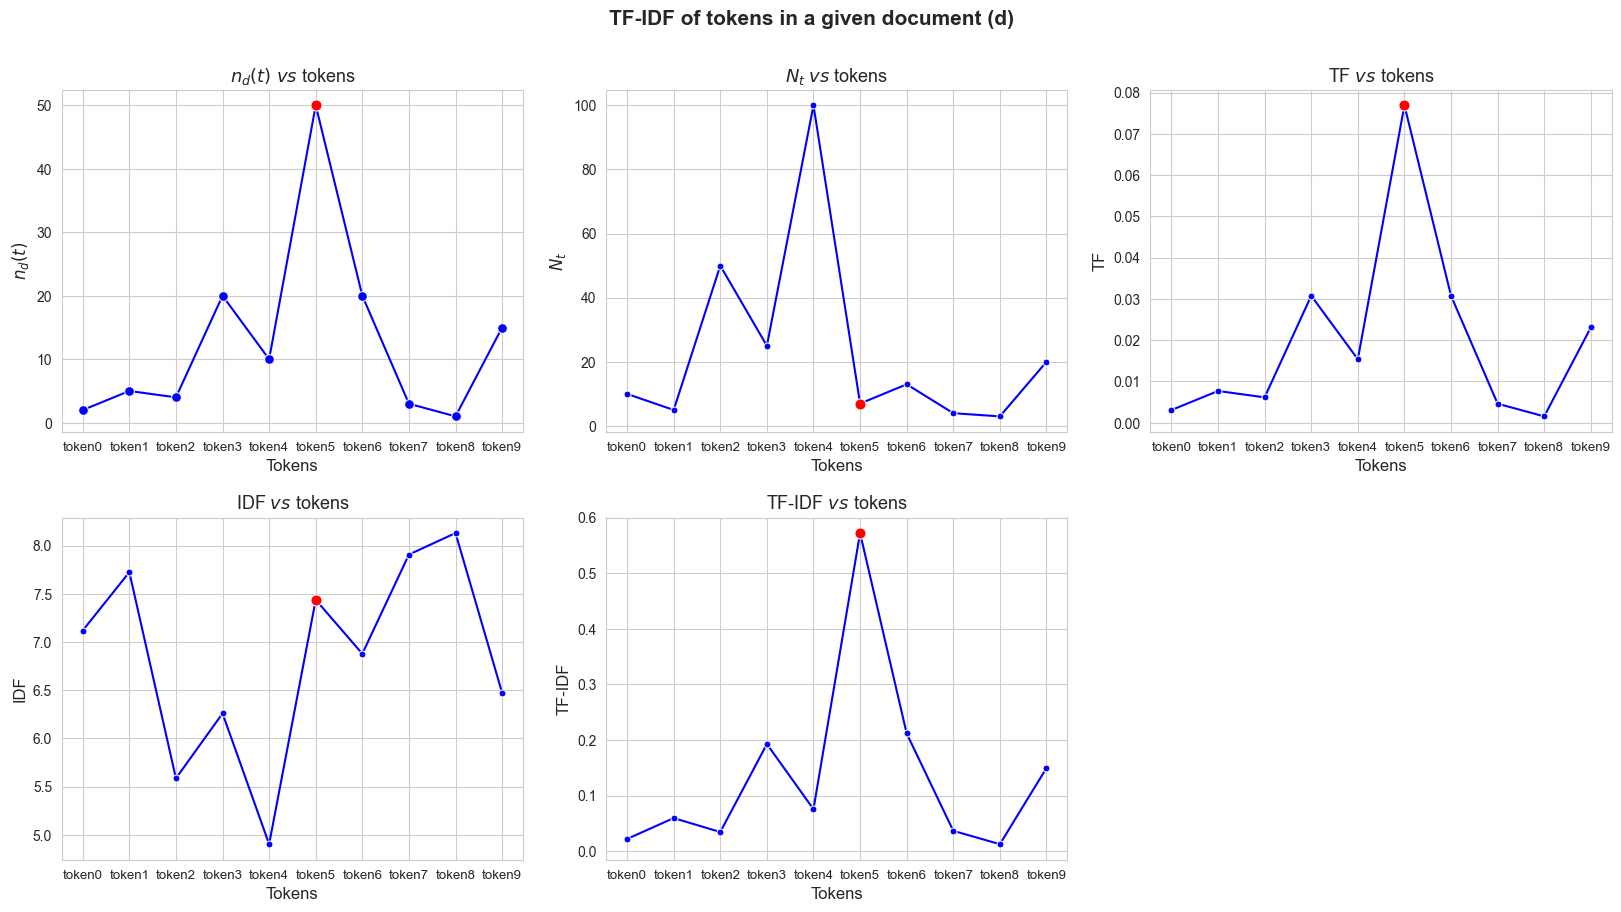

In [36]:
n_cols = 3
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,10))
axes = axes.flatten()

ax = sns.lineplot(y=ndt, x=tokens_toy, color='blue', marker='o',  markersize=7, ax=axes[0])
ax = sns.lineplot(y=[ndt[np.argmax(ndt)]], x=[tokens_toy[np.argmax(ndt)]], color='red', marker='o', markersize=8, ax=axes[0])
ax = sns.lineplot(y=Nt, x=tokens_toy, color='blue', marker='o',  markersize=5, ax=axes[1])
ax = sns.lineplot(y=[Nt[np.argmax(ndt)]], x=[tokens_toy[np.argmax(ndt)]], color='red', marker='o', markersize=8, ax=axes[1])
ax = sns.lineplot(y=TF_values, x=tokens_toy, color='blue', marker='o',  markersize=5, ax=axes[2])
ax = sns.lineplot(y=[TF_values[np.argmax(ndt)]], x=[tokens_toy[np.argmax(ndt)]], color='red', marker='o', markersize=8, ax=axes[2])
ax = sns.lineplot(y=IDF_values, x=tokens_toy, color='blue', marker='o',  markersize=5, ax=axes[3])
ax = sns.lineplot(y=[IDF_values[np.argmax(ndt)]], x=[tokens_toy[np.argmax(ndt)]], color='red', marker='o', markersize=8, ax=axes[3])
ax = sns.lineplot(y=TFIDF_values, x=tokens_toy, color='blue', marker='o',  markersize=5, ax=axes[4])
ax = sns.lineplot(y=[TFIDF_values[np.argmax(ndt)]], x=[tokens_toy[np.argmax(ndt)]], color='red', marker='o', markersize=8, ax=axes[4])

axes[0].set_ylabel('$n_d(t)$', size=12)
axes[1].set_ylabel('$N_t$', size=12)
axes[2].set_ylabel('TF', size=12)
axes[3].set_ylabel('IDF', size=12)
axes[4].set_ylabel('TF-IDF', size=12)

axes[0].set_title('$n_d(t)$ $vs$ tokens', fontsize=13)
axes[1].set_title('$N_t$ $vs$ tokens', fontsize=13)
axes[2].set_title('TF $vs$ tokens', fontsize=13)
axes[3].set_title('IDF $vs$ tokens', fontsize=13)
axes[4].set_title('TF-IDF $vs$ tokens', fontsize=13)

for i in range(0, len(axes)):
    axes[i].set_xlabel('Tokens', size=12)
    axes[i].tick_params(axis='x', rotation=0, labelsize=9.5)

for j in range(len(axes)-1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('TF-IDF of tokens in a given document (d)', fontsize=15, y=0.96, weight='bold')
plt.subplots_adjust(hspace=0.25, wspace=0.18) 
plt.show()

### **Computing TF-IDF** 

We compute the TF-IDF statistics for our data.

In [33]:
# Computing TF for our data-set
df = tokens_explode_df.group_by(['text_id','tokens', 'Fake']).agg(pl.col('tokens').count().alias('nd(t)'))
df2 = df.group_by('text_id').agg(pl.col('nd(t)').sum().alias('len(d)')).sort(by='text_id')
df3 = df.join(df2, on='text_id', how='inner')
tf_df = df3.with_columns((pl.col('nd(t)') / pl.col('len(d)')).alias('TF'))

# Computing IDF for our data-set
df4 = df.group_by(['tokens']).agg(pl.col('text_id').n_unique().alias('N(t)'))
N = len(news_df)
idf_df = df4.with_columns((np.log((N+1)/(pl.col('N(t)')+1))+1).alias('IDF')) # sklearn formula

# Computing TF-IDF for our data-set
tf_idf_df = tf_df.join(idf_df, on='tokens', how='inner')
tf_idf_df = tf_idf_df.with_columns((pl.col('TF') * pl.col('IDF')).alias('TF_IDF'))

The next table contains not only the TF-IDF of the tokens of each news, but also the different quantities that define the TF-IDF, for a better understanding of how this statistics behaves.

In [34]:
tf_idf_df.head()

text_id,tokens,Fake,nd(t),len(d),TF,N(t),IDF,TF_IDF
i32,str,i32,u32,u32,f64,u32,f64,f64
0,"""media""",1,3,250,0.012,8097,2.712798,0.032554
0,"""reality""",1,1,250,0.004,1978,4.121824,0.016487
0,"""supporters""",1,2,250,0.008,3845,3.457382,0.027659
0,"""december""",1,13,250,0.052,2124,4.050644,0.210633
0,"""tweet""",1,2,250,0.008,1952,4.135049,0.03308


### **Top tokens per news type based on TF-IDF**

#### **Using our TF-IDF values**

We compute the most frequent tokens depending on the news type, then we plot the top tokens in both groups.

In [35]:
min_df = 0.05 # For only taking into account tokens that appear at least in the 5 % of the documents
top_fake_tokens_tfidf_df = tf_idf_df.filter(pl.col('N(t)') > min_df*n_news).group_by(['tokens', 'Fake']).agg(pl.col('TF_IDF').mean()).filter(pl.col('Fake')==1).sort(by='TF_IDF', descending=True)
top_not_fake_tokens_tfidf_df = tf_idf_df.filter(pl.col('N(t)') > min_df*n_news).group_by(['tokens', 'Fake']).agg(pl.col('TF_IDF').mean()).filter(pl.col('Fake')==0).sort(by='TF_IDF', descending=True)

top_fake_tokens_tfidf_values = top_fake_tokens_tfidf_df['TF_IDF'].to_numpy()
top_fake_tokens_tfidf = top_fake_tokens_tfidf_df['tokens'].to_numpy()

top_not_fake_tokens_tfidf_values = top_not_fake_tokens_tfidf_df['TF_IDF'].to_numpy()
top_not_fake_tokens_tfidf = top_not_fake_tokens_tfidf_df['tokens'].to_numpy()

- **Barplots for top tokens**

  Plotting the top 15 tokens in the fake and not fake news, based on frequencies, as a barplot.

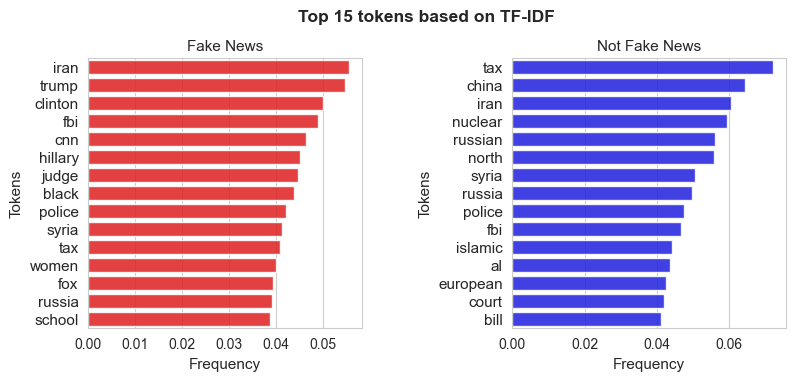

In [105]:
n_top = 15
fig, axs = plt.subplots(1,2, figsize=(9,3.5))
axes = axs.flatten()

ax = sns.barplot(y=top_fake_tokens_tfidf[:n_top], x=top_fake_tokens_tfidf_values[:n_top], 
                 color='red', alpha=0.85, ax=axes[0])
ax = sns.barplot(y=top_not_fake_tokens_tfidf[:n_top], x=top_not_fake_tokens_tfidf_values[:n_top], 
                 color='blue', alpha=0.85, ax=axes[1])

axes[0].set_title('Fake News', fontsize=11)
axes[1].set_title('Not Fake News', fontsize=11)

for i in range(0, len(axes)):
    axes[i].set_ylabel('Tokens', size=11)
    axes[i].set_xlabel('Frequency', size=11)
    axes[i].tick_params(axis='y', rotation=0, labelsize=11)

plt.suptitle(f'Top {n_top} tokens based on TF-IDF', size=12.5, weight='bold', y=1.02)
plt.subplots_adjust(hspace=0.25, wspace=0.55) 
plt.show()

- Computing the **genuine** fake and not fake tokens, namely, tokens that are in the top-15 fake tokens but not in the top-15 not fake tokens, and vice versa.

In [37]:
genuine_top_fake_tokens_tfidf_idx = np.array([x not in top_not_fake_tokens_tfidf[:n_top] for x in top_fake_tokens_tfidf[:n_top]])
genuine_top_not_fake_tokens_tfidf_idx = np.array([x not in top_fake_tokens_tfidf[:n_top] for x in top_not_fake_tokens_tfidf[:n_top]])

genuine_top_fake_tokens_tfidf = top_fake_tokens_tfidf[:n_top][genuine_top_fake_tokens_tfidf_idx]
genuine_top_fake_tokens_tfidf_values = top_fake_tokens_tfidf_values[:n_top][genuine_top_fake_tokens_tfidf_idx]

genuine_top_not_fake_tokens_tfidf = top_not_fake_tokens_tfidf[:n_top][genuine_top_not_fake_tokens_tfidf_idx]
genuine_top_not_fake_tokens_tfidf_values = top_not_fake_tokens_tfidf_values[:n_top][genuine_top_not_fake_tokens_tfidf_idx]

- **Word clouds for genuine top tokens**

   Plotting the top genuine tokens in the fake and not fake news as a word cloud.

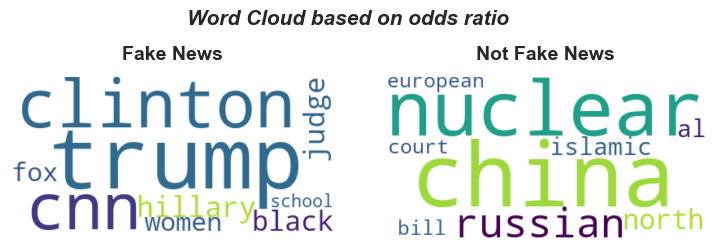

In [143]:
word_cloud_fake_data = {token: tfidf for token, tfidf in zip(genuine_top_fake_tokens_tfidf, genuine_top_fake_tokens_tfidf_values)}
word_cloud_not_fake_data = {token: tfidf for token, tfidf in zip(genuine_top_not_fake_tokens_tfidf, genuine_top_not_fake_tokens_tfidf_values)}
wordcloud_fake = WordCloud(width=400, height=200, background_color='white', random_state=123).generate_from_frequencies(word_cloud_fake_data)
wordcloud_not_fake = WordCloud(width=400, height=200, background_color='white', random_state=123).generate_from_frequencies(word_cloud_not_fake_data)

fig, axs = plt.subplots(1,2, figsize=(9,8))
axes = axs.flatten()

axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].imshow(wordcloud_not_fake, interpolation='bilinear')

axes[0].set_title('Fake News', fontsize=14, weight='bold', y=1.05)
axes[1].set_title('Not Fake News', fontsize=14, weight='bold', y=1.05)

for i in range(0, len(axes)):
    axes[i].axis('off') # Hide axis

plt.suptitle('Word Cloud based on odds ratio', weight='bold', style='italic', fontsize=15, y=0.68)
plt.subplots_adjust(hspace=0.25, wspace=0.15) 
plt.show()

- **Interpretation**

  - In this fake news word cloud the most prominent words are "Clinton," "Trump," "CNN," "judge," "black," "school," "fox," and "women." These words suggest that fake news articles might focus heavily on key figures and organizations involved in the American political scene, possibly framing narratives around them in a way that is not as common in genuine news sources.

  - This not fake word cloud highlights words like "China," "Russian," "nuclear," "Islamic," "European," "court," and "bill." The prominence of these terms indicates that genuine news might focus more on international relations, legal matters, and significant policy or security issues. These topics are more specialized and may require more in-depth reporting and analysis, which could explain their importance in the TF-IDF metric for not fake news.

Together, these clouds suggest that fake news may tend towards sensationalizing political figures and entities, potentially to attract attention or manipulate opinion, while genuine news appears to address broader international and policy-related topics, which might be less sensational but are significant to an informed public.






## **News Classification**

In this section we are going to develop several steps related with the classification of the news in fake and not fake.

The classifiers that we are going to use in this project are the following:

- Naive TF-IDF
- KNN
- Gaussian Naive 
- Multinomial Naive Bayes
- Complement Multinomial Naive Bayes
- Bernoulli Naive Bayes

In this section we are going to explain them.

### **Naive Bayes Classifiers**

Along this section assume that we have data for a categorical response $Y=(y_1,\dots , y_n)^\prime \in \mathbb{R}^n$ with $k$ categories $\mathcal{D}(Y)=\lbrace 0, 1,\dots, k-1 \rbrace$, and for $p$ predictors $X=(X_1, \dots, X_p)\in \mathbb{R}^{n\times p}$, where $X_j=(x_{1j}, \dots, x_{nj})^\prime$ is the vector with the $n$ observations of the $j$-th predictor and $x_i = (x_{i1}, \dots, x_{ip})^\prime$ is the vector with the values of the predictors for the $i$-th observation.

Applying the Bayes theorem we have the following:

$$P(Y=y_i | X=x_i) = \dfrac{\hspace{0.1cm} P(X=x_i | Y=y_i)\cdot P(Y=y_i)\hspace{0.1cm}}{P(X=x_i)}$$

**Naive assumption:** the predictors are independent $\hspace{0.1cm}\Rightarrow\hspace{0.1cm} $ $X_j \perp X_r \quad \forall j\neq r$

 Under this assumption: 

 $$P(X=x_i | Y=y_i) = P(X_1=x_{i1}, \dots, X_p=x_{ip} | Y=y_i) = \prod_{j=1}^p P(X_j = x_{ij} | Y=y_i)$$

Therefore, the Bayes theorem could be transform as:

$$P(Y=y_i | X=x_i) = \dfrac{\prod_{j=1}^p P(X_j = x_{ij} | Y=y_i)\cdot P(Y=y_i)}{P(X=x_i)} \propto \prod_{j=1}^p P(X_j = x_{ij} | Y=y_i)\cdot P(Y=y_i)$$

The prediction criteria in Naive Bayes classifiers consist of classify in the response class with more probability given the predictors data.

Given a new observation of the predictors $x_* = (x_{*1}, \dots , x_{*p})^\prime$, the response for it is predicted as follows:

   $$\widehat{y}_* = arg \underset{c \in \mathcal{D}(Y)}{Max} \widehat{P}(Y=c | X=x_*) = arg \underset{c \in \mathcal{D}(Y)}{Max}  \prod_{j=1}^p \widehat{P}(X_j = x_{*j} | Y=c)\cdot \widehat{P}(Y=c)$$


**How to estimate the involved probabilities?**

- $P(Y=c)$ is estimated as the relative frequency of the response class $c$ in the training set.

  $$\widehat{P}(Y=c) = \dfrac{\# \lbrace i=1,\dots n : y_i = c\rbrace}{n}$$

- The problematic point arises with the estimation of $P(X_j = x_{*j} | Y=c)$.

   The very naive option would be: 

   $$\widehat{P}(X_j = x_{*j} | Y=c) = \dfrac{\# \lbrace i=1,\dots,n : x_{ij} = x_{*j} \hspace{0.1cm};\hspace{0.1cm} y_i = c\rbrace }{\# \lbrace i=1,\dots,n : y_i = c\rbrace }$$

   The problem with this approach is that $\widehat{P}(X_j = x_{*j} | Y=c) =0$ for some predictor $j=1,\dots , p$ is a common scenario for any category $c$ of the response, specially whe we have predictors that are not strictly categorical, which is typical, specially in text classification where TF-IDF an word counts are the dominant options. An the problem of that scenario is that leads to $P(Y=c  | X=x_*)=0$ for any $c$, what means that the classification will be done by chance, which doesn't make sense.

  The avoid this problem, a probability distribution is assumed to estimate $P(X_j = x_{*j} | Y=c)$, and depending of the chosen distribution we have one naive Bayes or another. 





### **Gaussian Naive Bayes**

Assumes that:

$$X_j = x_{*j} | Y=c \hspace{0.1cm}\sim\hspace{0.1cm} N(\mu_{j,c}, \sigma^2_{j,c})$$

Where: 

$$\mu_{j,c} = \dfrac{1}{n_c} \cdot \sum_{\substack{i=1 \\ y_i=c}}^n x_{ij}$$

$$\sigma^2_{j,c} = \dfrac{1}{n_c} \cdot \sum_{\substack{i=1 \\ y_i=c}}^n (x_{ij} - \mu_{j,c})^2$$

 is the mean and variance, respectively, of $X_j$ for the train observations of the group $Y=c$.

Therefore:

$$\widehat{P}(X_j = x_{*j} | Y=c) = \int_{x_{*j}-\varepsilon}^{x_{*j}+\varepsilon} f_{N(\mu_{j,c}, \sigma^2_{j,c})}(x) dx \hspace{0.15cm} > \hspace{0.15cm} 0\quad\quad \varepsilon \rightarrow 0$$

This model is suitable when the predictors are continuous, like in the TF-IDF case.

### **Multinomial Naive Bayes**

This model is specially thought for text classification.  

This model assumes that:

$$\widehat{P}(X_j = x_{*j} | Y=c)  = \widehat{p}_{j,c}^{\hspace{0.1cm} x_{*j}}$$

Where:

$$\widehat{p}_{j,c} = \dfrac{n(t_j,c) + \alpha}{n_c + \alpha \cdot n}$$


$$n(t_j,c)= \sum_{\substack{i=1 \\ y_i=c}}^n f(t_j, d_i)$$

$$n_c = \sum_{\substack{i=1 \\ y_i=c}}^n len(d_i)$$

- $\widehat{p}_{j,c}$ is the training estimation of $P(t_j | Y=c)$, that is the probability of token $t_j$ is  in the group $Y=c$, namely, the relative frequency of the token $t_j$ in each document of the class $Y=c$.

- $n(t_j,c)$ is the frequency of the token $t_j$ in the training documents of the group $Y=c$.

- $n_c$ is the number of training documents of the class $Y=c$.


- $f(t_j, d_i)$ is the frequency of the token $t_j$ in the document $d_i$.

- $len(d_i)$ is the number of tokens of the document $d_i$.

- $\alpha \geq 0$ accounts for tokens not present in the learning samples and prevents zero probabilities in further computations. $\alpha = 1$  is called Laplace smoothing, while $\alpha < 1$ is called Lidstone smoothing.

 

This model is more suitable for discrete predictors (specially counting data), like word counts predictors, but it also usually works well with TF-IDF.

### **Bernoulli Naive Bayes**

This model is thought for text classification, as the previous one.

This model assumes that:

$$\widehat{P}(X_j = x_{*j} | Y=c)  = \widehat{p}_{j,c}^{\hspace{0.1cm} x_{*j}}\cdot (1- \widehat{p}_{j,c})^{1-x_{*j}} \quad x_{*j} \in \lbrace 0 , 1 \rbrace$$


This model is for dummy predictors, that could indicate wether the token appears or not in the document.

If the predictors are TF-IDF or word counts, the algorithm forces them to belong to $\lbrace 0 , 1 \rbrace$ using, for example, `MinMaxScaler(0,1)` and after that rounding the resulting values.

### **Categorical Naive Bayes**

This model assumes that the predictors are categorical variables and

$$\widehat{P}(X_j = x_{*j} | Y=c) = \dfrac{n(x_{*j},c) + \alpha}{n_c + \alpha\cdot h_j}$$

- $n(x_{*j},c)$ is the number of documents of the class $Y=c$ that has the category $X_j = x_{*j}$.

- $h_j = \#\mathcal{D}(X_j)$ is the number of unique categories of $X_j$.



This model can be used to classify individuals based on categorical predictors.

### **Complement Naive Bayes**

Is a modification of Multinomial Naive Bayes, specially designed for imbalanced classification problems.

### **TF-IDF Naive Classifier**

$\text{Top}_{train}(k_1 | Y= c) =$ indices of the top $k_1$ (`n_top_train`) tokens in the training documents of the class $Y=c$, according to their  TF-IDF *average* values.

$\text{Top}_{new}(k_2, i) = $ indices of the top $k_2$ (`n_top_new`) tokens in the (new) document $i$, according to their TF-IDF values.

$$\widehat{y}_i = arg \hspace{0.1cm}\underset{c \in \mathcal{D}(Y)}{Max} \hspace{0.1cm}\text{PropMatches}(\text{Top}_{new}(k_2, i), \text{Top}_{train}(k_1| Y= c))$$


- $\text{PropMatches}(\text{Top}_{new}(k_2, i), \text{Top}_{train}(k_1| Y= c))$ is the proportion of top tokens of the document $i$ that are top tokens of class $Y=c$ as well, that is, proportion of matches between the top tokens of document $i$ and top tokens of class $Y=c$.

If the document $i$ has many (or at least enough) top tokens that are top tokens of class $Y=c$ as well, then, it will be classify as class $c$.

### **Predictors and Response Definition**

Defining the predictors and the response, the outer-evaluation (train-test split) and the inner-evaluation (Kfold Cross Validation).

In [39]:
# Defining the predictors and the response
X = news_df['text'].to_numpy()
Y = news_df['Fake'].to_numpy()

### **Outer-Inner Evaluation Definition**

In [40]:
# Defining the outer-evaluation: train-test split.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, random_state=123)
# Defining dictionaries to save the inner scores and best parameters of the models
inner_scores, params, results = {}, {}, {}
# Defining the inner-evaluation: k-fold
inner = KFold(n_splits=3, shuffle=True, random_state=123)

### **Pipelines**

Defining the pipelines with the transformers and the classifiers.



In [41]:
pipelines = {}

pipelines['naive_tfidf'] = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(tokenizer=tokenizer, min_df=0.05, stop_words=stop_words, smooth_idf=False)),
    ('naive_tfidf', Naive_TFIDF_Classifier()) 
    ])

pipelines['gnb'] = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(tokenizer=tokenizer, min_df=0.05, stop_words=stop_words, smooth_idf=False)),
    ('sparsetodense', SparseToDense()),
    ('gnb', GaussianNB()) 
    ])

pipelines['mnb'] = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(tokenizer=tokenizer, min_df=0.05, stop_words=stop_words, smooth_idf=False)),
    ('mnb', MultinomialNB()) 
    ])

pipelines['cmnb'] = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(tokenizer=tokenizer, min_df=0.05, stop_words=stop_words, smooth_idf=False)),
    ('cmnb', ComplementNB()) 
    ])

pipelines['bnb'] = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(tokenizer=tokenizer, min_df=0.05, stop_words=stop_words, smooth_idf=False)),
    ('bnb', BernoulliNB()) 
    ])

### **Parameter Grids**

We define the parameter grids for all the pipelines, which will be used for HPO (hyperparameter optimization).

- Common grid for all the models.

In [122]:
def common_param_grid(trial):
    param_grid = {
        'tfidf_vectorizer__smooth_idf': trial.suggest_categorical('tfidf_vectorizer__smooth_idf', [True, False]),
        'tfidf_vectorizer__min_df': trial.suggest_categorical('tfidf_vectorizer__min_df', [0.03, 0.05, 0.07, 0.1, 0.15, 0.20, 0.25])
    }
    return param_grid

- Grid for Naive TF-IDF classifier

In [123]:
def param_grid_naive_TFIDF(trial):
    param_grid = common_param_grid(trial)
    param_grid.update({
        'naive_tfidf__n_top_tokens_train': trial.suggest_categorical('naive_tfidf__n_top_tokens_train',  [10, 20, 30, 40, 50, 60, 80, 100, 150, 200, 250]),
        'naive_tfidf__n_top_tokens_test': trial.suggest_categorical('naive_tfidf__n_top_tokens_test', [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 130, 150, 200, 250]),
    })
    return param_grid

- Grid for Gaussian Naive Bayes

In [124]:
def param_grid_GaussianNB(trial):
    param_grid = common_param_grid(trial)
    return param_grid

- Grid for Multinomial Naive Bayes

In [125]:
def param_grid_MultinominalNB(trial):
    param_grid = common_param_grid(trial)
    param_grid.update({
        'mnb__alpha': trial.suggest_float('mnb__alpha', 0, 10, step=0.05)
    })
    return param_grid

- Grid for Complement Multinomial Naive Bayes

In [126]:
def param_grid_ComplementMultinominalNB(trial):
    param_grid = common_param_grid(trial)
    param_grid.update({
        'cmnb__alpha': trial.suggest_float('cmnb__alpha', 0, 10, step=0.05)
    })
    return param_grid

- Grid for Bernoulli Naive Bayes

In [127]:
def param_grid_BernoulliNB(trial):
    param_grid = common_param_grid(trial)
    param_grid.update({
        'bnb__alpha': trial.suggest_float('bnb__alpha', 0, 10, step=0.05)
    })
    return param_grid

### **Hyper-parameter Optimization (HPO)**

#### **Naive TF-IDF Classifier**

In [ ]:
simple_eval = SimpleEvaluation(estimator=pipelines['naive_tfidf'], param_grid=param_grid_naive_TFIDF, 
                 inner=inner, search_method='optuna', scoring='accuracy', direction='maximize', 
                 n_trials=35, random_state=123)
simple_eval.fit(X=X_train, Y=Y_train)
inner_scores['TFIDF_Naive'] = simple_eval.inner_score
params['TFIDF_Naive'] = simple_eval.inner_best_params
results['TFIDF_Naive'] = simple_eval.inner_results

### **KNN Classifier**

In [ ]:
# Initializing the TfidfVectorizer.
# min_df=0.05 to include only the tokens that appear in at least 3 % documents
tfidf_vect = TfidfVectorizer(tokenizer=tokenizer, min_df=0.03, stop_words=stop_words, smooth_idf=True)
# Fitting the TfidfVectorizer with the training data.
tfidf_vect.fit(X_train)
# Defining train and test TF-IDF spare matrices.
X_train_tfidf_spare = tfidf_vect.transform(X_train)
X_test_tfidf_spare = tfidf_vect.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
inner_scores['KNN'] = np.mean(cross_val_score(estimator=knn, X=X_train_tfidf_spare, y=Y_train, scoring='accuracy', cv=inner)) # Time: 7.35 mins
params['KNN'] = knn.get_params()

### **Gaussian Naive Bayes Classifier**

In [ ]:

simple_eval = SimpleEvaluation(estimator=pipelines['gnb'], param_grid=param_grid_GaussianNB, 
                 inner=inner, search_method='optuna', scoring='accuracy', direction='maximize', 
                 n_trials=35, random_state=150)
simple_eval.fit(X=X_train, Y=Y_train)
inner_scores['Gaussian_Naive_Bayes'] = simple_eval.inner_score
params['Gaussian_Naive_Bayes'] = simple_eval.inner_best_params
results['Gaussian_Naive_Bayes'] = simple_eval.inner_results

### **Multinomial Naive Bayes Classifier**

In [ ]:
simple_eval = SimpleEvaluation(estimator=pipelines['mnb'], param_grid=param_grid_MultinominalNB, 
                 inner=inner, search_method='optuna', scoring='accuracy', direction='maximize', 
                 n_trials=40, random_state=123)
simple_eval.fit(X=X_train, Y=Y_train)
inner_scores['Multinomial_Naive_Bayes'] = simple_eval.inner_score
params['Multinomial_Naive_Bayes'] = simple_eval.inner_best_params
results['Multinomial_Naive_Bayes'] = simple_eval.inner_results

### **Complement Multinomial Naive Bayes Classifier**

In [ ]:
simple_eval = SimpleEvaluation(estimator=pipelines['cmnb'], param_grid=param_grid_ComplementMultinominalNB, 
                 inner=inner, search_method='optuna', scoring='accuracy', direction='maximize', 
                 n_trials=45, random_state=123)
simple_eval.fit(X=X_train, Y=Y_train)
inner_scores['Complement_Multinomial_Naive_Bayes'] = simple_eval.inner_score
params['Complement_Multinomial_Naive_Bayes'] = simple_eval.inner_best_params
results['Complement_Multinomial_Naive_Bayes'] = simple_eval.inner_results

### **Bernoulli Naive Bayes Classifier**

In [ ]:
simple_eval = SimpleEvaluation(estimator=pipelines['bnb'], param_grid=param_grid_BernoulliNB, 
                 inner=inner, search_method='optuna', scoring='accuracy', direction='maximize', 
                 n_trials=50, random_state=123)
simple_eval.fit(X=X_train, Y=Y_train)
inner_scores['Bernoulli_Naive_Bayes'] = simple_eval.inner_score
params['Bernoulli_Naive_Bayes'] = simple_eval.inner_best_params
results['Bernoulli_Naive_Bayes'] = simple_eval.inner_results

### **Model selection**

- Saving the results

In [145]:
# Saving the results as pickle files
'''
with open('params', 'wb') as file:
    pickle.dump(params, file)

with open('inner_scores', 'wb') as file:
    pickle.dump(inner_scores, file)
'''

- Opening the results

In [42]:
with open('params', 'rb') as file:
        params = pickle.load(file)

with open('inner_scores', 'rb') as file:
        inner_scores = pickle.load(file)

In [43]:
models = np.array(list(inner_scores.keys()))
inner_scores_values = np.array(list(inner_scores.values()))
best_model = models[np.argmax(inner_scores_values)]

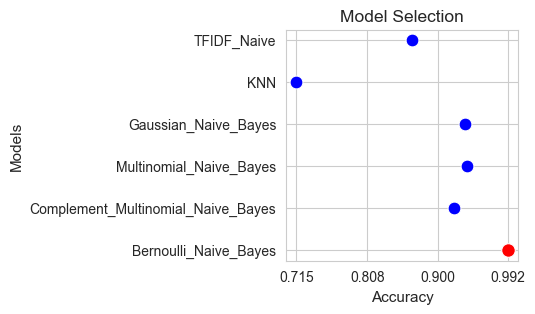

The best model is Bernoulli_Naive_Bayes and its best parameters are {'tfidf_vectorizer__smooth_idf': True, 'tfidf_vectorizer__min_df': 0.2, 'bnb__alpha': 6.15}


In [124]:
plt.figure(figsize=(3, 3))
ax = sns.scatterplot(x=inner_scores_values, y=models, color='blue', s=85)
ax = sns.scatterplot(x=np.max(inner_scores_values), 
                     y=[best_model], color='red', s=95)
plt.title('Model Selection', size=12.5)
ax.set_ylabel('Models', size=11)
ax.set_xlabel('Accuracy', size=11)
min = np.min(inner_scores_values)
max = np.max(inner_scores_values)
plt.xticks(np.round(np.linspace(min,max, 4), 3), fontsize=10)
plt.yticks(fontsize=10)
plt.show()
print('The best model is', best_model,  'and its best parameters are', params[best_model])

- **Conclusions**

  The Naive Bayes models performs pretty well in this case, specially the Bernoulli Naive Bayes, which is the best model according to the inner evaluation.

  We can also see that the Laplace smoothing is important in this case, since the best `bnb_alpha` is far away from zero.

### Estimation of future performance

Estimation of future performance with the best model, that is the Bernoulli Naive Bayes.

In [ ]:
pipelines['bnb'].set_params(**params[best_model]) 
pipelines['bnb'].fit(X=X_train, y=Y_train)
Y_test_hat = pipelines['bnb'].predict(X=X_test)
future_performance = accuracy_score(y_pred=Y_test_hat, y_true=Y_test)
print(f'The estimated future performance for the best model is {np.round(future_performance, 3)}, which is almost perfect!')

The confusion matrix of the most model is:

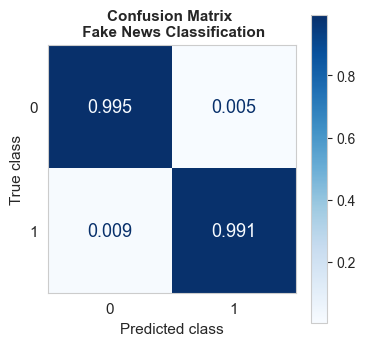

In [122]:
cm = confusion_matrix(y_pred=Y_test_hat, y_true=Y_test, normalize='true', labels=pipelines['bnb'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipelines['bnb'].classes_)

fig, axs = plt.subplots(figsize=(4,4))
disp.plot(ax=axs, cmap=plt.cm.Blues, values_format='.3f', text_kw={'fontsize': 13})
plt.title('Confusion Matrix \n Fake News Classification', weight='bold', fontsize=11)
axs.set_xlabel('Predicted class', size=11)
axs.set_ylabel('True class', size=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(False)
plt.show()

- The confusion matrix shows that both classes are really well classified, but the not fake news are a bit better classified.

## **Sentiment Analysis**


The compound polarity score, as computed by the SentimentIntensityAnalyzer (SIA) in NLTK, is a normalized score that represents the overall sentiment of a piece of text. It's derived from the positive, negative, and neutral scores computed for the text.

-  Positive Score: The positive score represents the proportion of words in the text that are classified as positive. It's computed by counting the occurrences of positive words and normalizing it by the total number of words in the text.

- Negative Score: Similar to the positive score, the negative score represents the proportion of words classified as negative. It's computed by counting the occurrences of negative words and normalizing it by the total number of words in the text.

- Neutral Score: The neutral score represents the proportion of words classified as neutral. It's computed similarly to the positive and negative scores.

- Compound Score (compound): The compound score is the sum of all lexicon ratings normalized between -1 and 1. This score is calculated using the formula:

 $$\text{Compound Score} = \dfrac{\text{sum of the ratings}}{\text{sum of the squares of the ratings} + \text{alpha}}$$

​
 
Here, alpha is a normalization factor. The ratings are the scores of individual words in the lexicon. The compound score is then adjusted to be between -1 (most negative) and 1 (most positive).



Positive, negative, and neutral words are typically defined based on sentiment lexicons or dictionaries. These lexicons contain lists of words along with their associated sentiment polarity. Here's a general explanation of how positive, negative, and neutral words are defined:

- Positive Words: Positive words are those that convey a positive sentiment or emotion. These words are often associated with concepts like happiness, joy, satisfaction, or approval. Examples of positive words include "happy," "love," "great," "wonderful," "awesome," etc.

- Negative Words: Negative words, on the other hand, convey a negative sentiment or emotion. They are associated with concepts like sadness, anger, disappointment, or disapproval. Examples of negative words include "sad," "hate," "terrible," "awful," "disappointing," etc.

- Neutral Words: Neutral words are those that do not carry a strong positive or negative sentiment. They are typically neutral in tone and can include words that are factual, descriptive, or contextually ambiguous. Examples of neutral words include "the," "is," "and," "are," "but," etc.

In [47]:
sentiment_name = lambda s: 'Negative' if s == -1 else 'Positive' if s == 1 else 'Neutral'
news_type_name = lambda c: 'Fake' if c == 1 else 'Not Fake'   
sid = SentimentIntensityAnalyzer()
sentiment_scores = []
for i in range(0,len(X)):
    sentiment_scores.append(sid.polarity_scores(X[i])['compound'])
sentiment_scores = np.array(sentiment_scores)
positive_news = np.where(sentiment_scores > 0.05)
negative_news = np.where(sentiment_scores < - 0.05)
neutral_news = np.where((sentiment_scores >= -0.05) & (sentiment_scores <= 0.05))
Z = np.zeros(len(X)) # Z = 0 <--> neutral news
Z[positive_news] = 1 # Z = 1 <--> positive news
Z[negative_news] = -1 # Z = -1 <--> negative news
prop_sentiment_class = {c: {sentiment_name(s): np.mean(Z[Y==c] == s) for s in [-1, 0, 1]} for c in np.unique(Y)}
prop_class_sentiment = {s: {news_type_name(c): np.mean(Y[Z==s] == c) for c in np.unique(Y)} for s in [-1, 0, 1]}

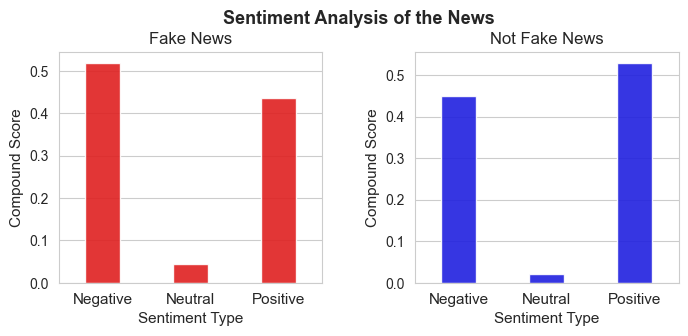

In [133]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axes = axs.flatten()

ax = sns.barplot(x=list(prop_sentiment_class[1].keys()), 
                 y=list(prop_sentiment_class[1].values()), 
                 color='red', alpha=0.90, width=0.4, ax=axes[0])
ax = sns.barplot(x=list(prop_sentiment_class[0].keys()), 
                 y=list(prop_sentiment_class[0].values()), 
                 color='blue', alpha=0.90, width=0.4, ax=axes[1])

axes[0].set_title('Fake News', fontsize=12)
axes[1].set_title('Not Fake News', fontsize=12)

for i in range(0, len(axes)):
    axes[i].set_ylabel('Compound Score', size=11)
    axes[i].set_xlabel('Sentiment Type', size=11)
    axes[i].tick_params(axis='x', rotation=0, labelsize=11)

plt.suptitle('Sentiment Analysis of the News', size=13, weight='bold', y=1.02)
plt.subplots_adjust(hspace=0.25, wspace=0.35) 
plt.show()

- **Interpretation**

    - Fake news has a higher proportion of news with negative feelings than positive and neutral.

    - Not fake news have a higher proportion of news with positive feelings than negative and neutral.

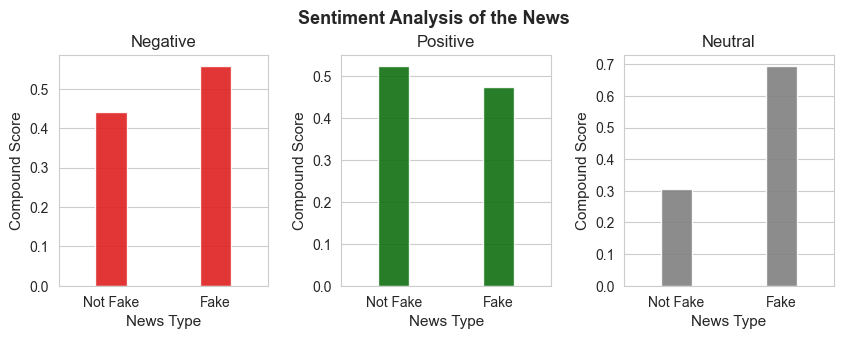

In [132]:
fig, axs = plt.subplots(1,3, figsize=(10,3))
axes = axs.flatten()

ax = sns.barplot(x=list(prop_class_sentiment[-1].keys()), 
                 y=list(prop_class_sentiment[-1].values()), 
                 color='red', alpha=0.90, width=0.3, ax=axes[0])
ax = sns.barplot(x=list(prop_class_sentiment[1].keys()), 
                 y=list(prop_class_sentiment[1].values()), 
                 color='green', alpha=0.90, width=0.3, ax=axes[1])
ax = sns.barplot(x=list(prop_class_sentiment[0].keys()), 
                 y=list(prop_class_sentiment[0].values()), 
                 color='grey', alpha=0.90, width=0.3, ax=axes[2])

axes[0].set_title('Negative', fontsize=12)
axes[1].set_title('Positive', fontsize=12)
axes[2].set_title('Neutral', fontsize=12)

for i in range(0, len(axes)):
    axes[i].set_ylabel('Compound Score', size=11)
    axes[i].set_xlabel('News Type', size=11)
    axes[i].tick_params(axis='x', rotation=0, labelsize=10)

plt.suptitle('Sentiment Analysis of the News', size=13, weight='bold', y=1.03)
plt.subplots_adjust(hspace=0.25, wspace=0.35) 
plt.show()

- **Interpretation**

  - Within the negative news the most part are fake news.

  - Within the positive news the most part are not fake news. 

  - Within the neutral news the most part are fake news, and the different is quite significative.